# Split image to text lines before OCR

In [94]:
import os.path
# Importing the OpenCV library
import cv2 as cv

%load_ext autoreload
%autoreload 1
%aimport img_proc
import img_proc as imp
from config import image_path, image_filename, start_row_number


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
# Reading the image using imread() function
gray = imp.read_gray_image(os.path.join(image_path, image_filename))


Height = 3888, Width = 5184


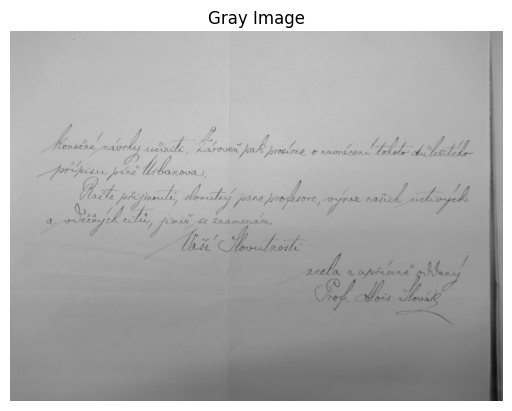

In [96]:
image = gray
# Extracting the height and width of an image
h, w = image.shape[:2]
# Displaying the height and width
print("Height = {}, Width = {}".format(h, w))# Display the gray image
imp.show_image(image, title='Gray Image', cmap='gray')

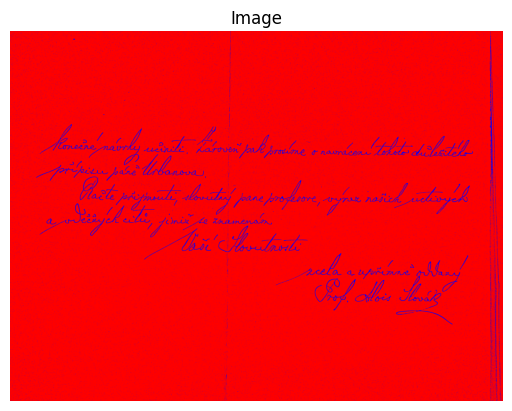

In [97]:
# Use adaptive thresholding to better separate text from light gray shadows
mask = imp.thresholding(image)
imp.show_image(mask, cmap="bwr")


bbox: [0, 0, 5184, 3888]


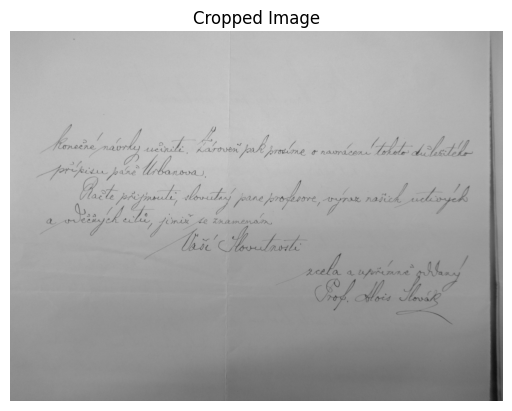

In [98]:
crop = imp.crop_dark_borders(image)
imp.show_image(crop, title='Cropped Image', cmap='gray')

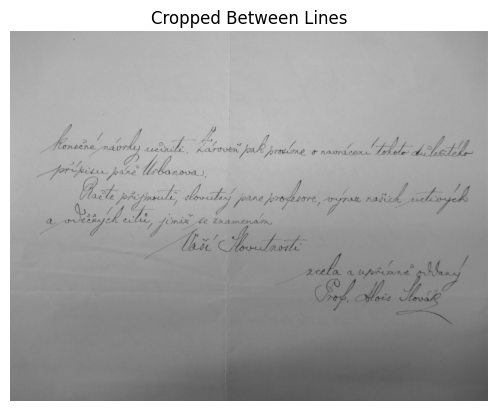

In [99]:

image = crop
cropped_between_lines = imp.crop_to_content(image)
imp.show_image(cropped_between_lines, title='Cropped Between Lines', cmap='gray')

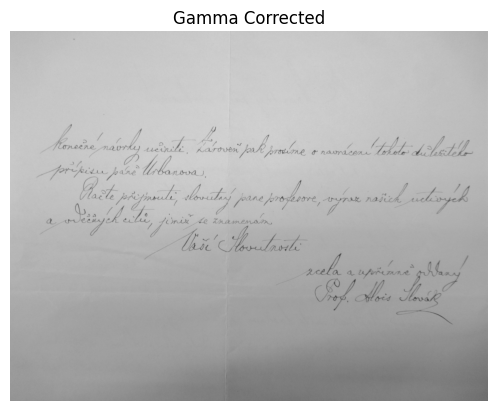

In [100]:
image = cropped_between_lines
# Improve image: increase lightness, keep dark characters, remove gray background
corrected = imp.gamma_correction(image)
imp.show_image(corrected, title='Gamma Corrected', cmap='gray')


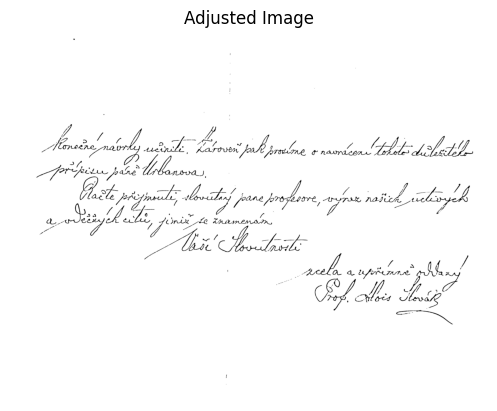

In [101]:

image = corrected
adaptive = imp.improve_image(image)
adjusted = imp.morphological_operations(adaptive)

imp.show_image(adjusted, title='Adjusted Image', cmap='gray')
imp.save_image(os.path.join(image_path, 'adjusted.png'), adjusted)



In [102]:
image = adjusted
# save the result
extension = image_filename.split('.')[-1]
output_path = os.path.join(image_path, 
                           image_filename.replace(f'.{extension}',
                           f'_clean.{extension}'))
imp.save_image(output_path, image)

In [128]:
boxes, character_size, big_character_size = imp.find_contours(image)
print("Number of detected boxes", len(boxes))
print(f"Výška řádku (90. percentil): {big_character_size}")
print(f"Výška znaku (50. percentil): {character_size}")

Initial number of detected boxes 165
Character size (50. percentil): 55.0
 (90. percentil): 237.80000000000007
Number of detected boxes 153
Výška řádku (90. percentil): 237.80000000000007
Výška znaku (50. percentil): 55.0


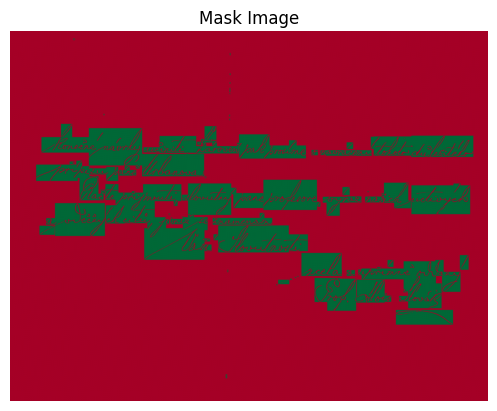

In [129]:
# make a mask image from the boxes
mask_image = imp.create_mask_image(image, boxes)
# show the mask image with source image on the background  
imp.show_image(imp.combine_with_mask(image, mask_image), 
               title='Mask Image', cmap='RdYlGn')

In [164]:
lines = imp.split_lines(image, mask_image, boxes, character_size, big_character_size)
# Show number of detected lines
print(f"Počet detekovaných řádků: {len(lines)}")

Line ends at y=1278, counts=3743, line_width=4411
Line box: (332, 79, 4538, 1333), number of boxes: 46
Line ends at y=1517, counts=1516, line_width=3743
Line box: (276, 1293, 1786, 485), number of boxes: 12
Line ends at y=1779, counts=3556, line_width=3916
Line box: (732, 1527, 4105, 491), number of boxes: 29
Line ends at y=2018, counts=2302, line_width=3584
Line box: (311, 1699, 2355, 472), number of boxes: 21
Line ends at y=2257, counts=1647, line_width=2310
Line box: (311, 2044, 4509, 464), number of boxes: 11
Line ends at y=2496, counts=1378, line_width=1647
Line box: (2285, 2333, 1924, 275), number of boxes: 11
Line ends at y=2735, counts=1323, line_width=1597
Line box: (2800, 2421, 1791, 518), number of boxes: 17
Line ends at y=2974, counts=601, line_width=1323
Line box: (2269, 2782, 1114, 866), number of boxes: 6
Line ends at y=3629, counts=15, line_width=601
Line box: (2269, 3609, 13, 39), number of boxes: 0
Počet detekovaných řádků: 9


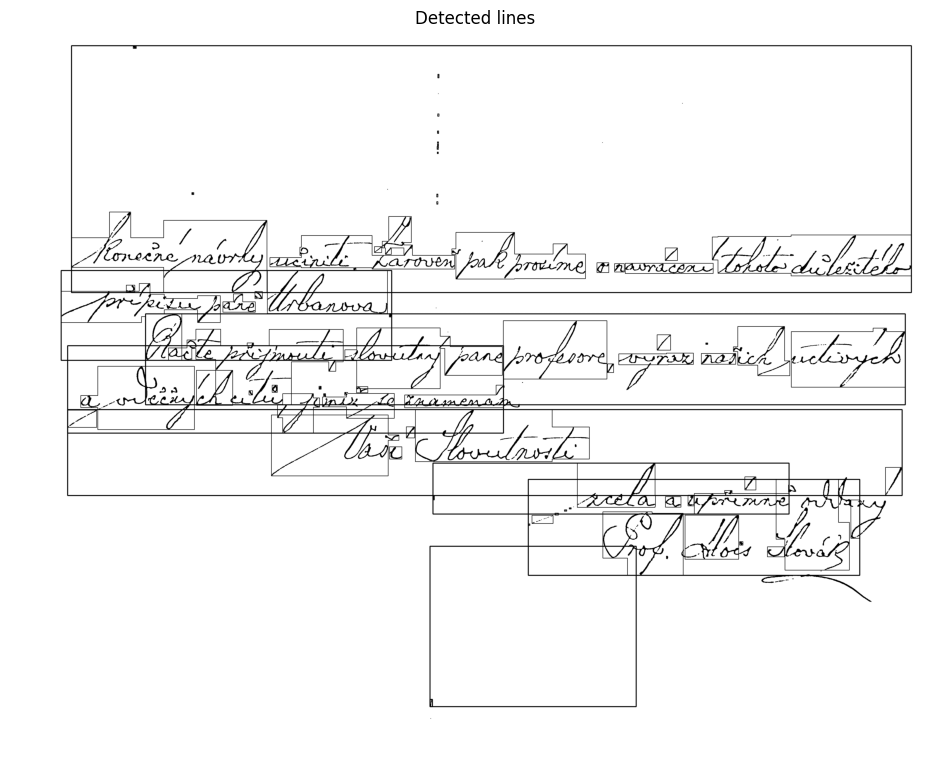

In [166]:
imp.show_lines(image, lines)

Line 0: 332, 79, 4538, 1333


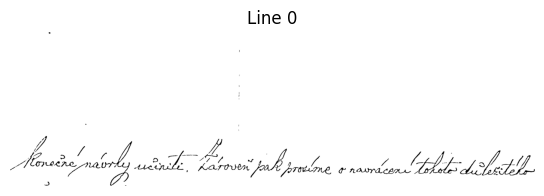

Line 1: 276, 1293, 1786, 485


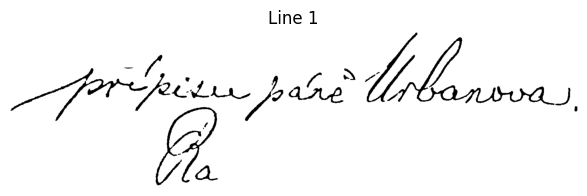

Line 2: 732, 1527, 4105, 491


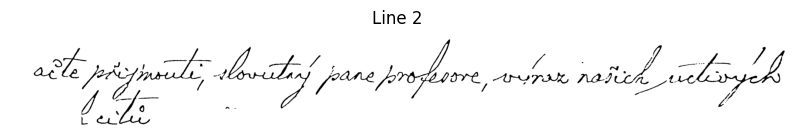

Line 3: 311, 1699, 2355, 472


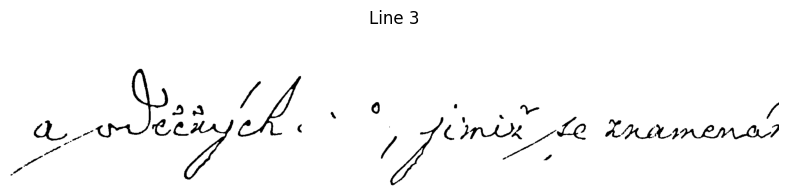

Line 4: 311, 2044, 4509, 464


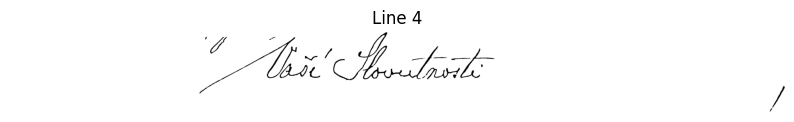

Line 5: 2285, 2333, 1924, 275


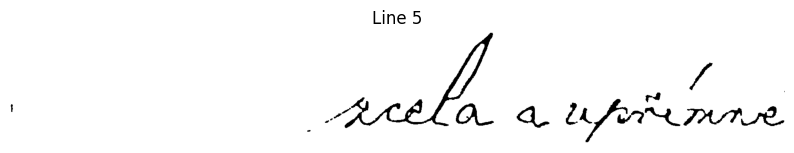

Line 6: 2800, 2421, 1791, 518


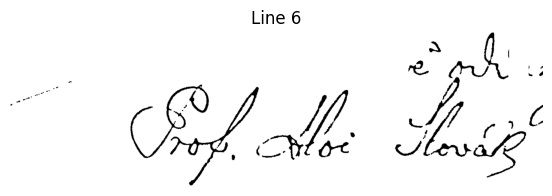

Line 7: 2269, 2782, 1114, 866


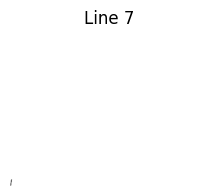

Line 8: 2269, 3609, 13, 39


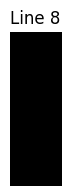

In [167]:
# Display each line
imp.show_separated_lines(lines)

In [169]:
imp.save_lines(image_path, image_filename, start_row_number, lines)